## 1. Loading Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


2024-05-18 07:58:19.839015: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 07:58:19.839156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 07:58:19.976831: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Preprocessing I

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


## 3. Load Data

In [3]:
train_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/train'
test_dir =  '../input/chest-xray-pneumonia/chest_xray/chest_xray/test'
validation_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/val'


## 4. Display Sample Data 

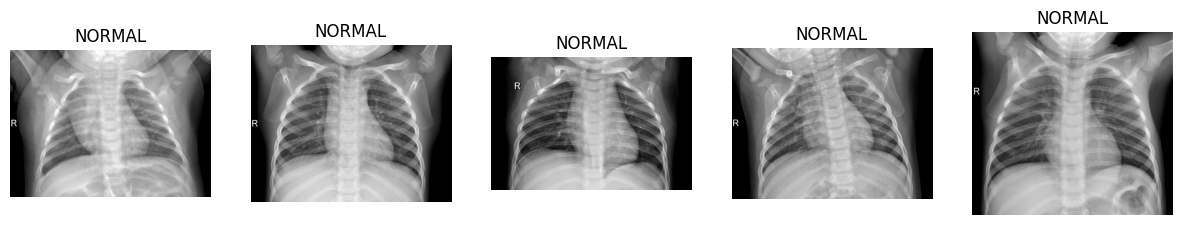

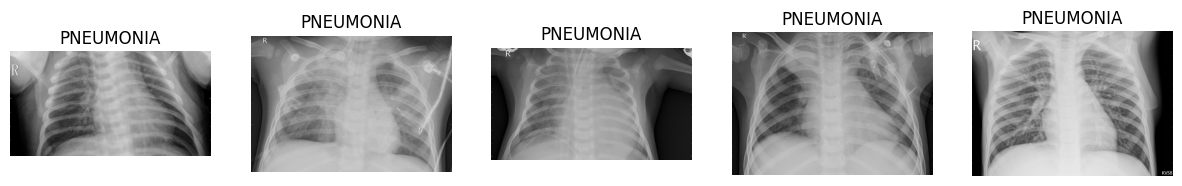

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import random

def display_sample_images(directory, class_name):
    class_dir = os.path.join(directory, class_name)
    sample_images = random.sample(os.listdir(class_dir), 5)
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(class_dir, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(class_name)
        plt.axis('off')
    plt.show()

display_sample_images(train_dir, 'NORMAL')
display_sample_images(train_dir, 'PNEUMONIA')

## 5. Preprocessing II

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## 6. Lets Deploy A CNN Model

In [6]:
# Model Architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Convolutional layer with 32 filters and a 3x3 kernel
    MaxPooling2D((2, 2)),                                              # Max-pooling layer with 2x2 pool size
    Conv2D(64, (3, 3), activation='relu'),                             # Convolutional layer with 64 filters and a 3x3 kernel
    MaxPooling2D((2, 2)),                                              # Max-pooling layer with 2x2 pool size
    Conv2D(128, (3, 3), activation='relu'),                            # Convolutional layer with 128 filters and a 3x3 kernel
    MaxPooling2D((2, 2)),                                              # Max-pooling layer with 2x2 pool size
    Flatten(),                                                         # Flatten the 3D output to 1D tensor
    Dense(512, activation='relu'),                                     # Fully connected layer with 512 units
    Dropout(0.5),                                                      # Dropout layer to prevent overfitting
    Dense(1, activation='sigmoid')                                     # Output layer with a single neuron for binary classification
])

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


## 7. Lets Start Training

In [7]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Train 
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-18 07:58:50.526898: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49284: 7.84353, expected 6.92193
2024-05-18 07:58:50.526958: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49286: 7.76792, expected 6.84632
2024-05-18 07:58:50.526974: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49287: 6.15631, expected 5.23472
2024-05-18 07:58:50.526992: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49288: 6.71859, expected 5.797
2024-05-18 07:58:50.527006: E external/local_xla/xla/service/gpu/buffer_co

  1/163 ━━━━━━━━━━━━━━━━━━━━ 46:07 17s/step - accuracy: 0.5938 - loss: 0.6834

I0000 00:00:1716019137.146435      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.7405 - loss: 0.8464

2024-05-18 08:01:10.959620: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148273: 4.10347, expected 3.58648
2024-05-18 08:01:10.959705: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149075: 3.91455, expected 3.39756
2024-05-18 08:01:10.959715: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149093: 3.88055, expected 3.36356
2024-05-18 08:01:10.959723: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149362: 4.10975, expected 3.59276
2024-05-18 08:01:10.959733: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149850: 3.98709, expected 3.4701
2024-05-18 08:01:10.959751: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 151973: 3.89678, expected 3.37979
2024-05-18 08:01:10.959763: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 153061: 4.10204, expected 3.58504
2024-05-18 08:01:10.9

163/163 ━━━━━━━━━━━━━━━━━━━━ 155s 850ms/step - accuracy: 0.7410 - loss: 0.8425 - val_accuracy: 0.8750 - val_loss: 0.5359 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 644ms/step - accuracy: 0.8368 - loss: 0.3483 - val_accuracy: 0.5625 - val_loss: 0.6876 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 641ms/step - accuracy: 0.8652 - loss: 0.2974 - val_accuracy: 0.6250 - val_loss: 0.6750 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 635ms/step - accuracy: 0.8766 - loss: 0.2962 - val_accuracy: 0.7500 - val_loss: 0.5474 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 626ms/step - accuracy: 0.8882 - loss: 0.2563 - val_accuracy: 0.6875 - val_loss: 0.5941 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 642ms/step - accuracy: 0.8890 - loss: 0.2675 - val_accuracy: 0.7500 - val_loss: 0.6406 - learning_rate: 0.0010


## 8. Model Evaluation  

### A. model summary

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,189,829 (508.08 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,793,220 (338.72 MB)

### B. Confusion Matrix

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 382ms/step


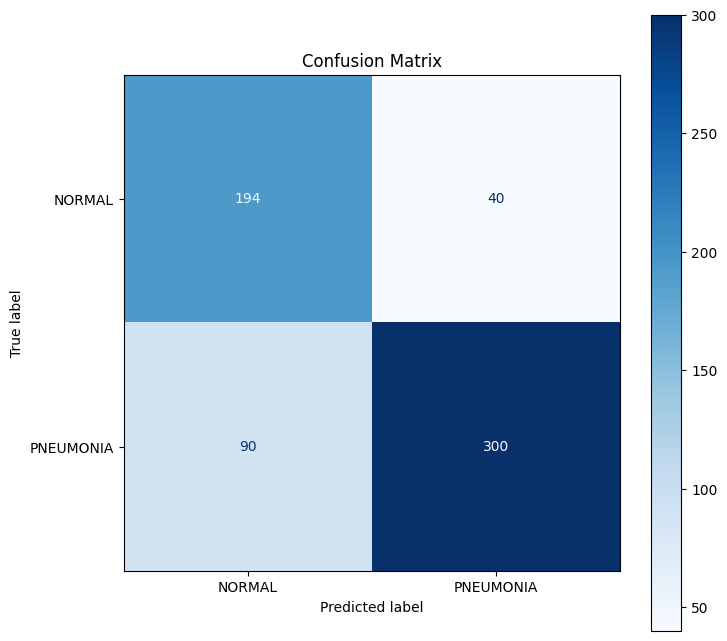

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Ensure the test generator is reset
test_generator.reset()

# Get the true labels and predictions
test_labels = test_generator.classes
test_pred_prob = model.predict(test_generator)
test_pred_classes = (test_pred_prob > 0.5).astype("int32").flatten()

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])

# Plot confusion matrix and save as PNG
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), values_format='d')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()


### C. Classification Report

In [10]:
report = classification_report(test_labels, test_pred_classes, target_names=['NORMAL', 'PNEUMONIA'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.68      0.83      0.75       234
   PNEUMONIA       0.88      0.77      0.82       390

    accuracy                           0.79       624
   macro avg       0.78      0.80      0.79       624
weighted avg       0.81      0.79      0.79       624

